In [ ]:
# Plot the forecast verification against reanalysis data (for ERA5 only):
# Plot normalized 'drmse' in lat-height coordinate
# initial built: 2025/01/22

# Has been transformed to py in the following directory:
# /scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/plot_forecast_verification_temp.py
# as of 2025/??/??

import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
print(cartopy.__version__)


In [ ]:
datahome  = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/forecast_verification_ERA5/data/'
#timerange = '2022062000_2022080500_24'
timerange = '2022062300_2022080200_24'
#timerange = '2022061900_2022063000_24'

#dirname   = 'FC_full_clr_cld-FC_full_clr_cld_low_sym_tri'
#dirname   = 'FC_full_CTRL-FC_full_clr_cld_low_sym_tri'
#dirname   = 'FC_full_CTRL-FC_full_clr_cld_sym_tri'
#dirname   = 'FC_full_CTRL-FC_full_only_clr'
#dirname   = 'FC_full_CTRL-FC_full_clr_cld'
#dirname   = 'FC_full_CTRL-FC_full_clr_cld_low'
dirname   = 'FC_full_CTRL-FC_full_CTRL_noinf'
#dirname   = 'FC_ctrl-FC_ctrl_noinf'

regions = '' # '_land', '_ocean', '' (global)

#fcsthrs = ['00','24']
#fcsthrs   = [24,48,72,96,120]
#fcsthrs   = [24,48,72,96,120,144,168,192]
fcsthrs   = ['00','24','48','72','96','120','144','168','192']

exps      = dirname.split('-')
expref    = exps[0]
exptest   = exps[1]
ncdir = os.path.join(datahome, dirname, timerange)

In [ ]:
explabel={'FC_full_CTRL':       'CTRL',
          'FC_full_CTRL_noinf': 'NOINF',
          'FC_full_clr_cld_low_sym_tri': 'CLR-CLD-cloud-low'}


In [ ]:
# read netcdfs:
qz={}; tz={}; uz={}; clwz={};                          # zonal mean for fields
dqz={}; dtz={}; duz={}; dclwz={};                      # absolute zonal mean error relative to ERA5
dqz_norm={}; dtz_norm={}; duz_norm={}; dclwz_norm={};  # normalized zonal mean error relative to exps[0]

dqg={}; dtg={}; dug={}; dclwg={};                      # absolute global mean error relative to ERA5
dqg_norm={}; dtg_norm={}; dug_norm={}; dclwg_norm={};  # normalized global error relative to exps[0]

s95_q={}; s95_t={}; s95_u={}; s95_clw={};
s95_q_region={}; s95_t_region={}; s95_u_region={}; s95_clw_region={};

d95_q_region={}; d95_t_region={}; d95_u_region={}; d95_clw_region={};


q={};  t={};  u={};  clw={};                     # forecast mean (3-D)
dq={}; dt={}; du={}; dclw={};                    # forecast bias (3-D)
q_rmse={}; t_rmse={}; u_rmse={}; clw_rmse={};    # RMSE (3-D)

# normalized error and significant levels:
for exp in exps:
    print(f"now processing {exp} ...")
    
    qz[exp]={}; tz[exp]={}; uz[exp]={}; clwz[exp]={};
    dqz[exp]={}; dtz[exp]={}; duz[exp]={}; dclwz[exp]={};
    dqz_norm[exp]={}; dtz_norm[exp]={}; duz_norm[exp]={}; dclwz_norm[exp]={};  

    dqg[exp]={}; dtg[exp]={}; dug[exp]={}; dclwg[exp]={};                      
    dqg_norm[exp]={}; dtg_norm[exp]={}; dug_norm[exp]={}; dclwg_norm[exp]={};  
    
    s95_q[exp]={}; s95_t[exp]={}; s95_u[exp]={}; s95_clw[exp]={};
    s95_q_region[exp]={}; s95_t_region[exp]={}; s95_u_region[exp]={}; s95_clw_region[exp]={};
    
    d95_q_region[exp]={}; d95_t_region[exp]={}; d95_u_region[exp]={}; d95_clw_region[exp]={};

    q[exp]={}; t[exp]={}; u[exp]={}; clw[exp]={};
    dq[exp]={}; dt[exp]={}; du[exp]={}; dclw[exp]={};
    q_rmse[exp]={}; t_rmse[exp]={}; u_rmse[exp]={}; clw_rmse[exp]={};

    for tt in fcsthrs:
        print(f"forecast hour = {tt} ...")
        if exp != expref: 
            # normalized relative error (zonal mean)
            f = nc.Dataset(f"{ncdir}/dzmean_rmse{region}_{exp}_f{tt}.nc")
            lat = f.variables['latitude'][:]
            lev = f.variables['level'][:]
            dqz_norm[exp][tt] = f.variables['q'][:]
            dtz_norm[exp][tt] = f.variables['t'][:]
            duz_norm[exp][tt] = f.variables['u'][:]
            dclwz_norm[exp][tt] = f.variables['clwmr'][:]

            d95 = nc.Dataset(f"{ncdir}/d95{region}_{exp}_f{tt}.nc")
            d95_q = d95.variables['q'][:]
            d95_t = d95.variables['t'][:]
            d95_u = d95.variables['u'][:]    
            d95_clw = d95.variables['clwmr'][:]    

            s95_q[exp][tt] = np.abs(d95_q/dqz_norm[exp][tt])>1.0
            s95_t[exp][tt] = np.abs(d95_t/dtz_norm[exp][tt])>1.0
            s95_u[exp][tt] = np.abs(d95_u/duz_norm[exp][tt])>1.0  
            s95_clw[exp][tt] = np.abs(d95_clw/dclwz_norm[exp][tt])>1.0  
            
            ### (read only ocean to replace area below 850 hPa) normalized relative error (zonal mean)
            f = nc.Dataset(f"{ncdir}/dzmean_rmse_ocean_{exp}_f{tt}.nc")
            lat = f.variables['latitude'][:]
            lev = f.variables['level'][:]
            tmp_dqz_norm = f.variables['q'][:]
            tmp_dtz_norm = f.variables['t'][:]
            tmp_duz_norm = f.variables['u'][:]
            tmp_dclwz_norm = f.variables['clwmr'][:]

            d95 = nc.Dataset(f"{ncdir}/d95_ocean_{exp}_f{tt}.nc")
            d95_q = d95.variables['q'][:]
            d95_t = d95.variables['t'][:]
            d95_u = d95.variables['u'][:]    
            d95_clw = d95.variables['clwmr'][:]    

            tmp_s95_q = np.abs(d95_q/tmp_dqz_norm)>1.0
            tmp_s95_t = np.abs(d95_t/tmp_dtz_norm)>1.0
            tmp_s95_u = np.abs(d95_u/tmp_duz_norm)>1.0  
            tmp_s95_clw = np.abs(d95_clw/tmp_dclwz_norm)>1.0  
            
            ### replace:
            dqz_norm[exp][tt][-6:,:] = tmp_dqz_norm[-6:,:]
            dtz_norm[exp][tt][-6:,:] = tmp_dtz_norm[-6:,:]
            duz_norm[exp][tt][-6:,:] = tmp_duz_norm[-6:,:]
            dclwz_norm[exp][tt][-6:,:] = tmp_dclwz_norm[-6:,:]
            
            s95_q[exp][tt][-6:,:] = tmp_s95_q[-6:,:]
            s95_t[exp][tt][-6:,:] = tmp_s95_t[-6:,:] 
            s95_u[exp][tt][-6:,:] = tmp_s95_u[-6:,:] 
            s95_clw[exp][tt][-6:,:] = tmp_s95_clw[-6:,:]             
            
            # normalized relative error (regional mean)
            dqg_norm[exp][tt] = {};
            dtg_norm[exp][tt] = {};
            dug_norm[exp][tt] = {};
            dclwg_norm[exp][tt] = {};

            d95_q_region[exp][tt] = {};
            d95_t_region[exp][tt] = {};
            d95_u_region[exp][tt] = {};
            d95_clw_region[exp][tt] = {};
            
            s95_q_region[exp][tt] = {};
            s95_t_region[exp][tt] = {};
            s95_u_region[exp][tt] = {};
            s95_clw_region[exp][tt] = {};
            
            for avg_region in ['global','NH','SH','TR']:
                f = nc.Dataset(f"{ncdir}/d{avg_region}mean_rmse{region}_{exp}_f{tt}.nc")
                dqg_norm[exp][tt][avg_region] = f.variables['q'][:]
                dtg_norm[exp][tt][avg_region] = f.variables['t'][:]
                dug_norm[exp][tt][avg_region] = f.variables['u'][:]
                dclwg_norm[exp][tt][avg_region] = f.variables['clwmr'][:]

                d95 = nc.Dataset(f"{ncdir}/d95_{avg_region}{region}_{exp}_f{tt}.nc")
                d95_q_region[exp][tt][avg_region] = d95.variables['q'][:]
                d95_t_region[exp][tt][avg_region] = d95.variables['t'][:]
                d95_u_region[exp][tt][avg_region] = d95.variables['u'][:]    
                d95_clw_region[exp][tt][avg_region] = d95.variables['clwmr'][:]    

                s95_q_region[exp][tt][avg_region] = np.abs(d95_q_region[exp][tt][avg_region]/dqg_norm[exp][tt][avg_region])>1.0
                s95_t_region[exp][tt][avg_region] = np.abs(d95_t_region[exp][tt][avg_region]/dtg_norm[exp][tt][avg_region])>1.0
                s95_u_region[exp][tt][avg_region] = np.abs(d95_u_region[exp][tt][avg_region]/dug_norm[exp][tt][avg_region])>1.0  
                s95_clw_region[exp][tt][avg_region] = np.abs(d95_clw_region[exp][tt][avg_region]/dclwg_norm[exp][tt][avg_region])>1.0  

                ### (read only ocean to replace area below 850 hPa) normalized relative error (zonal mean)
                f = nc.Dataset(f"{ncdir}/d{avg_region}mean_rmse_ocean_{exp}_f{tt}.nc")
                tmp_dqg_norm = f.variables['q'][:]
                tmp_dtg_norm = f.variables['t'][:]
                tmp_dug_norm = f.variables['u'][:]
                tmp_dclwg_norm = f.variables['clwmr'][:]

                d95 = nc.Dataset(f"{ncdir}/d95_{avg_region}_ocean_{exp}_f{tt}.nc")
                tmp_d95_q_region = d95.variables['q'][:]
                tmp_d95_t_region = d95.variables['t'][:]
                tmp_d95_u_region = d95.variables['u'][:]    
                tmp_d95_clw_region = d95.variables['clwmr'][:]    

                tmp_s95_q_region = np.abs(tmp_d95_q_region/tmp_dqg_norm)>1.0
                tmp_s95_t_region = np.abs(tmp_d95_t_region/tmp_dtg_norm)>1.0
                tmp_s95_u_region = np.abs(tmp_d95_u_region/tmp_dug_norm)>1.0  
                tmp_s95_clw_region = np.abs(tmp_d95_clw_region/tmp_dclwg_norm)>1.0 
                
                ### replace:
                dqg_norm[exp][tt][avg_region][-6:] = tmp_dqg_norm[-6:]
                dtg_norm[exp][tt][avg_region][-6:] = tmp_dtg_norm[-6:]
                dug_norm[exp][tt][avg_region][-6:] = tmp_dug_norm[-6:]
                dclwg_norm[exp][tt][avg_region][-6:] = tmp_dclwg_norm[-6:]
                
                s95_q_region[exp][tt][avg_region][-6:] = tmp_s95_q_region[-6:]
                s95_t_region[exp][tt][avg_region][-6:] = tmp_s95_t_region[-6:]
                s95_u_region[exp][tt][avg_region][-6:] = tmp_s95_u_region[-6:]  
                s95_clw_region[exp][tt][avg_region][-6:] = tmp_s95_clw_region[-6:]
                
            
        # absolute zonal mean error
        f = nc.Dataset(f"{ncdir}/zmean_rmse{region}_{exp}_f{tt}.nc")
        dqz[exp][tt] = f.variables['q'][:]
        dtz[exp][tt] = f.variables['t'][:]
        duz[exp][tt] = f.variables['u'][:]    
        dclwz[exp][tt] = f.variables['clwmr'][:]    

        # forecast mean (3D)
        f = nc.Dataset(f"{ncdir}/fcst_mean{region}_{exp}_f{tt}.nc")
        lon = f.variables['longitude'][:]
        q[exp][tt] = f.variables['q'][:]
        t[exp][tt] = f.variables['t'][:]
        u[exp][tt] = f.variables['u'][:] 
        clw[exp][tt] = f.variables['clwmr'][:] 
        
        # zonal mean of forecast mean:
        qz[exp][tt] = np.mean(q[exp][tt], axis=2)
        tz[exp][tt] = np.mean(t[exp][tt], axis=2)
        uz[exp][tt] = np.mean(u[exp][tt], axis=2)
        clwz[exp][tt] = np.mean(clw[exp][tt], axis=2)
        
        '''
        # forecast bias (3D)
        f = nc.Dataset(f"{ncdir}/bias{region}_{exp}_f{tt}.nc")
        dq[exp][tt] = f.variables['q'][:]
        dt[exp][tt] = f.variables['t'][:]
        du[exp][tt] = f.variables['u'][:] 
        dclw[exp][tt] = f.variables['clwmr'][:] 
        
        # forecast rmse (3D)
        f = nc.Dataset(f"{ncdir}/rmse{region}_{exp}_f{tt}.nc")
        q_rmse[exp][tt] = f.variables['q'][:]
        t_rmse[exp][tt] = f.variables['t'][:]
        u_rmse[exp][tt] = f.variables['u'][:]
        clw_rmse[exp][tt] = f.variables['clwmr'][:]       
        '''

In [ ]:
dqg_norm['FC_full_CTRL_noinf']['00']['global'].shape

In [ ]:
lev[-6:]

In [ ]:

indices = np.where(~dtz_norm[exptest]['00'].mask)  # Use `~` to invert the mask

In [ ]:
filled_arr = s95_t[exptest][tt].filled(True)

In [ ]:
# Temperature -- 
# only plot experiment difference (exptest - expref) without significance level

save_fig = False

fig_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/T/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
for tt in fcsthrs:
    for exptest in exps[1:]:
    #exptest   = 'clr_and_cld_0.05'

        lats, levs = np.meshgrid(lat, lev)

        # absolute temperature
        vmin_abs = -0.12
        vmax_abs =  0.12

        # Main Plot section:

        # figure size:
        fig, ax = plt.subplots(figsize=(7, 3.5))

        contour2 = ax.pcolormesh(lats, levs, tz[exptest][tt] - tz[expref][tt], cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
        ax.invert_yaxis()
        
        ax.set_xlabel('latitude',fontsize=13)
        ax.set_xticks([-90,-60,-30,0,30,60,90])
        ax.set_ylabel('height (hPa)',fontsize=13)
        ax.set_title(f'T (t={tt}h) ({explabel[exptest]} - {explabel[expref]})',fontsize=16)
        ax.set_ylim(1010,20)
        ax.grid(True)
        
        ax.tick_params(axis='x', labelsize=13)  
        ax.tick_params(axis='y', labelsize=13) 
        
        # set colorbar
        cbar = fig.colorbar(contour2,location='right',aspect=25)
        cbar.ax.tick_params(labelsize=11)  # Set fontsize for tick labels
        cbar.set_label('T (K)', fontsize=12)
        
        plt.tight_layout()

        if save_fig:
            plt.savefig(f"{fig_dir}/T_expdiff_t{tt}{region}_{exptest}_ref_{expref}.png", dpi=300, bbox_inches='tight')
        #plt.show()

In [ ]:
# Humidity -- 
# only plot experiment difference (exptest - expref) without significance level

save_fig = False

fig_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/HUM/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
for tt in fcsthrs:
    for exptest in exps[1:]:
    #exptest   = 'clr_and_cld_0.05'

        lats, levs = np.meshgrid(lat, lev)

        # absolute humidity
        vmin_abs = -0.1
        vmax_abs =  0.1

        # Main Plot section:

        # figure size:
        fig, ax = plt.subplots(figsize=(7, 3.5))

        contour2 = ax.pcolormesh(lats, levs, (qz[exptest][tt] - qz[expref][tt])*1e3, cmap='BrBG', vmin=vmin_abs, vmax=vmax_abs)
        ax.invert_yaxis()
        
        ax.set_xlabel('latitude',fontsize=13)
        ax.set_xticks([-90,-60,-30,0,30,60,90])
        ax.set_ylabel('height (hPa)',fontsize=13)
        ax.set_title(f'Q (t={tt}h) ({explabel[exptest]} - {explabel[expref]})',fontsize=16)
        ax.set_ylim(1010,20)
        ax.grid(True)
        
        ax.tick_params(axis='x', labelsize=13)  
        ax.tick_params(axis='y', labelsize=13) 
        
        # set colorbar
        cbar = fig.colorbar(contour2,location='right',aspect=25)
        cbar.ax.tick_params(labelsize=11)  # Set fontsize for tick labels
        cbar.set_label('Q (g/kg)', fontsize=12)
        
        plt.tight_layout()

        if save_fig:
            plt.savefig(f"{fig_dir}/HUM_expdiff_t{tt}{region}_{exptest}_ref_{expref}.png", dpi=300, bbox_inches='tight')
        plt.show()

In [ ]:
# Temperature -- 
# (1) zonal mean RMSE normalized rel.to reference experiment
# (2) experiment difference (exptest - expref)

save_fig = False

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/T/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
for tt in fcsthrs:
    for exptest in exps[1:]:
    #exptest   = 'clr_and_cld_0.05'

        lats, levs = np.meshgrid(lat, lev)

        # normalized temperature
        vmin_norm = -0.05
        vmax_norm =  0.05

        # absolute temperature
        vmin_abs = -0.2
        vmax_abs =  0.2

        # Main Plot section:

        # figure size:
        fig = plt.figure(figsize=(14,4))

        # define the subplots
        ax1 = fig.add_subplot(1, 2, 1)  # Add subplot at position 1
        ax2 = fig.add_subplot(1, 2, 2)  # Add subplot at position 2

        # ax1: normalized error
        contour1=ax1.pcolormesh(lats, levs, dtz_norm[exptest][tt], cmap='RdBu_r', vmin=vmin_norm, vmax=vmax_norm)
        ax1.invert_yaxis()
        
        filled_arr = s95_t[exptest][tt].filled(True)
        ax1.plot(np.ma.array(lats, mask=filled_arr), levs, 'k+', ms=2.5)
        #ax1.plot(np.ma.array(lats, mask=s95_t[exptest][tt]), levs, 'k+', ms=2.5)
        
        ax1.set_xlabel('latitude')
        ax1.set_xticks([-90,-60,-30,0,30,60,90])

        ax1.set_ylabel('height (hPa)')
        ax1.set_title(f'drmse T (t={tt}h) ({exptest} - {expref}), Ref=ERA5')
        ax1.set_ylim(1010,20)
        ax1.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour1,location='bottom',aspect=40)
        cbar.set_label('normalized drmse (%)')

        # ax2: experiment difference
        contour2 = ax2.pcolormesh(lats, levs, tz[exptest][tt] - tz[expref][tt], cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
        ax2.invert_yaxis()
        
        filled_arr = s95_t[exptest][tt].filled(True)
        ax2.plot(np.ma.array(lats, mask=filled_arr), levs, 'k+', ms=2.5)
        #ax2.plot(np.ma.array(lats, mask=s95_t[exptest][tt]), levs, 'k+', ms=2.5)
        ax2.set_xlabel('latitude')
        ax2.set_xticks([-90,-60,-30,0,30,60,90])
        ax2.set_ylabel('height (hPa)')
        ax2.set_title(f'T (t={tt}h) ({exptest} - {expref})')
        ax2.set_ylim(1010,20)
        ax2.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour2,location='bottom',aspect=40)
        cbar.set_label('T (K)')    

        if save_fig:
            plt.savefig(f"{fig_dir}/T_drmse_and_expdiff_t{tt}{region}_{exptest}_ref_{expref}.png")
        plt.show()

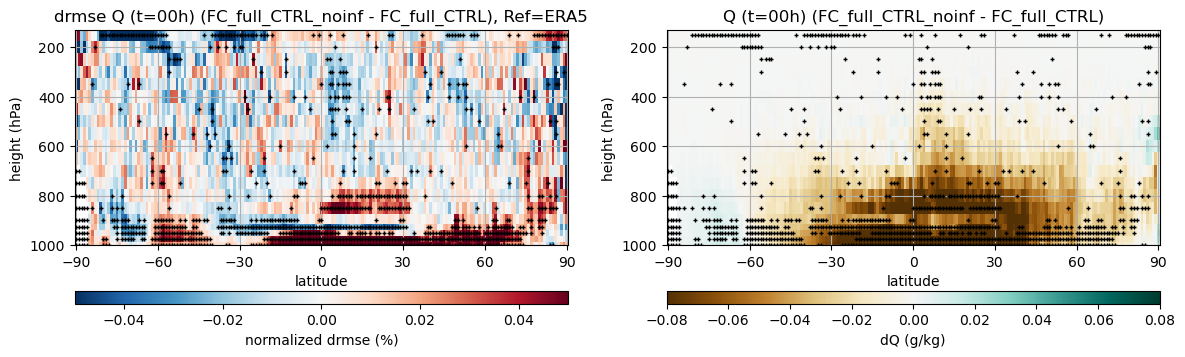

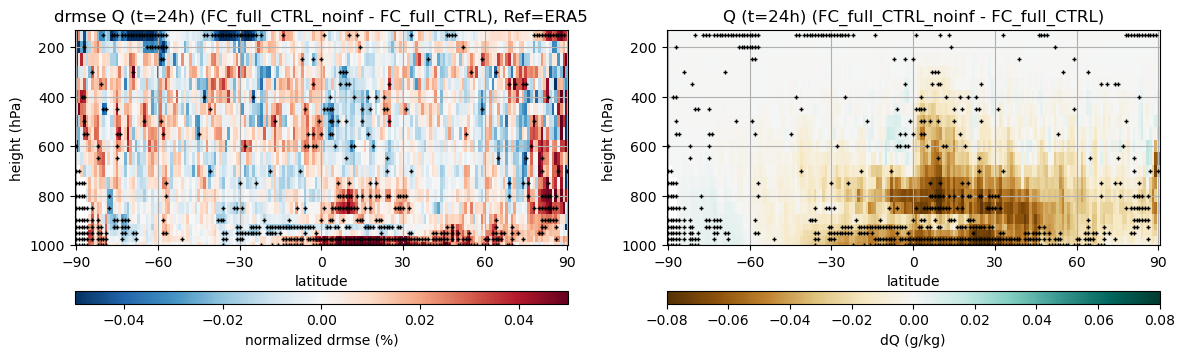

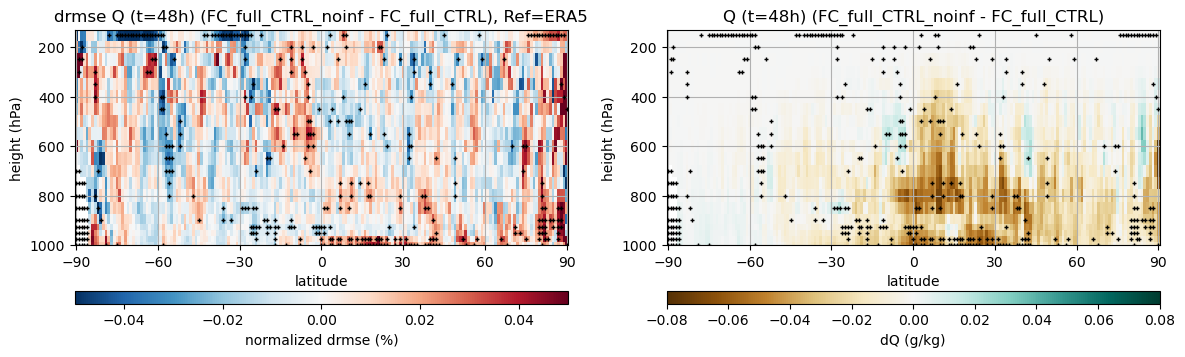

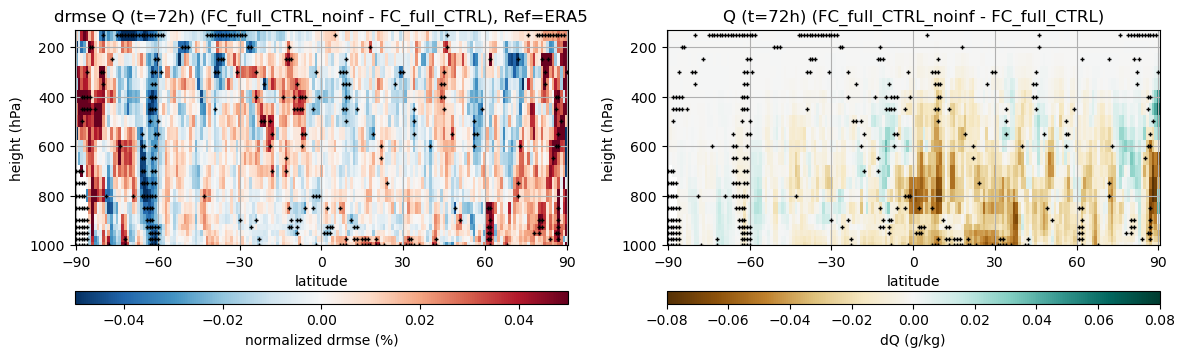

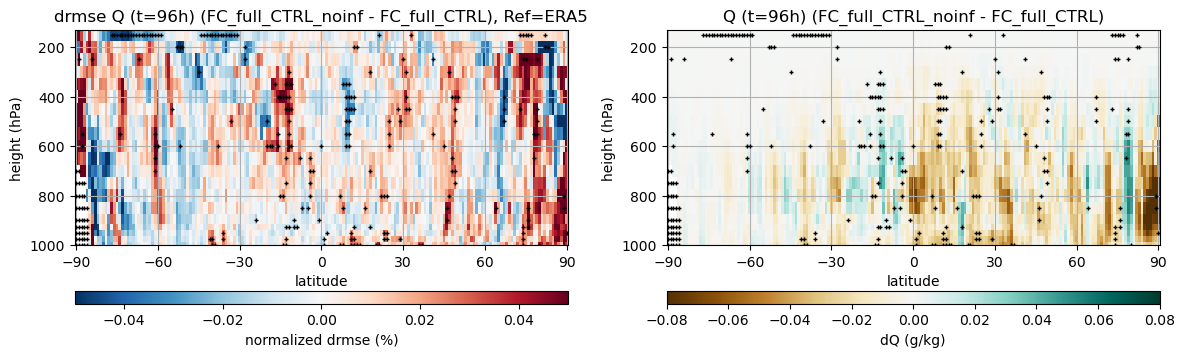

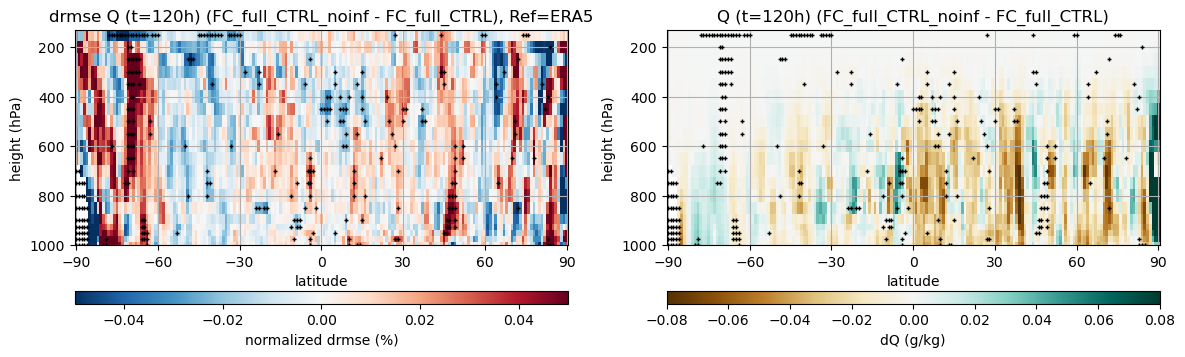

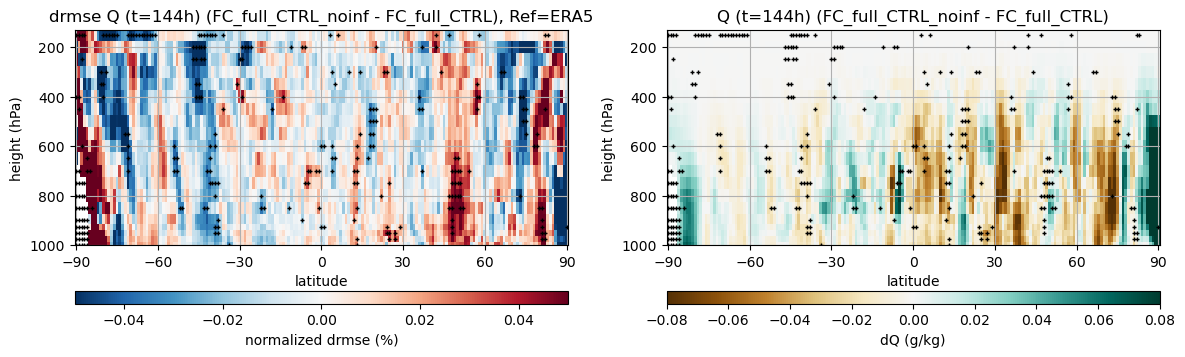

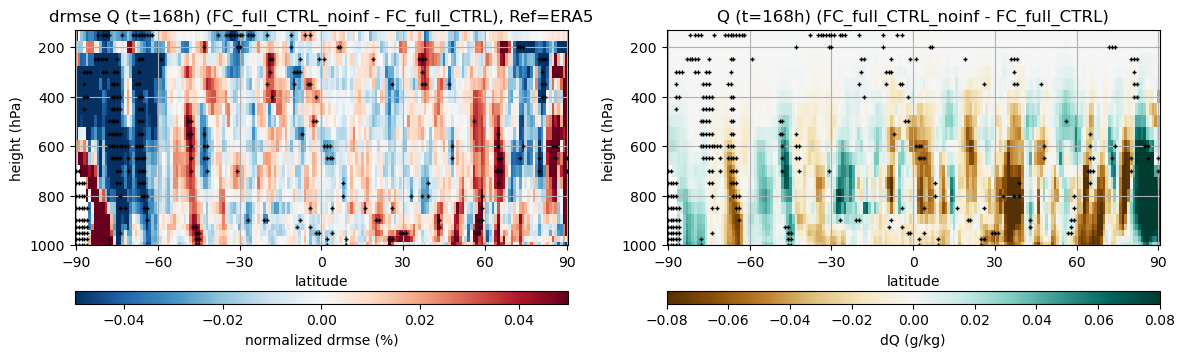

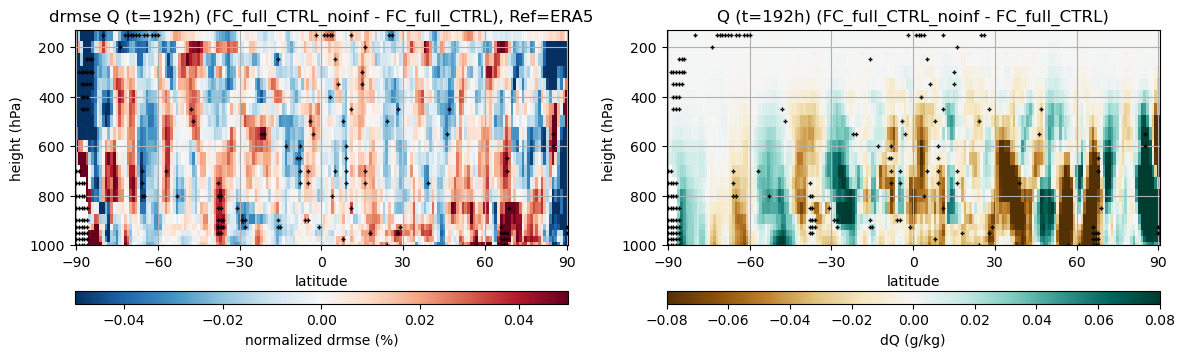

In [51]:
# Humidity --
# (1) zonal mean RMSE normalized rel.to reference experiment
# (2) experiment difference (exptest - expref)

save_fig = False

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/HUM/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
for tt in fcsthrs:
    for exptest in exps[1:]:

        lats, levs = np.meshgrid(lat, lev)

        # normalized relative humidity
        vmin_norm = -0.05
        vmax_norm =  0.05

        # absolute humidity
        vmin_abs = -0.08
        vmax_abs =  0.08

        # Main Plot section:

        # figure size:
        fig = plt.figure(figsize=(14,4))

        # define the subplots
        ax1 = fig.add_subplot(1, 2, 1)  # Add subplot at position 1
        ax2 = fig.add_subplot(1, 2, 2)  # Add subplot at position 2

        # ax1: normalized error
        contour1=ax1.pcolormesh(lats, levs, dqz_norm[exptest][tt], cmap='RdBu_r', vmin=vmin_norm, vmax=vmax_norm)
        ax1.invert_yaxis()
        ax1.plot(np.ma.array(lats, mask=s95_q[exptest][tt]), levs, 'k+', ms=2.5)
        ax1.set_xlabel('latitude')
        ax1.set_xticks([-90,-60,-30,0,30,60,90])
        ax1.set_ylabel('height (hPa)')
        ax1.set_title(f'drmse Q (t={tt}h) ({exptest} - {expref}), Ref=ERA5')
        ax1.set_ylim(1000,130)
        ax1.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour1,location='bottom',aspect=40)
        cbar.set_label('normalized drmse (%)')

        '''
        # ax2: absoulte error
        contour2 = ax2.pcolormesh(lats, levs, (dq[exptest] - dq[expref])*1e3, cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
        ax2.invert_yaxis()
        ax2.plot(np.ma.array(lats, mask=s95_q[exptest]), levs, 'k+', ms=2.5)
        ax2.set_xlabel('latitude')
        ax2.set_ylabel('height (hPa)')
        ax2.set_title(f'drmse Q ({exptest} - {expref}), Ref=ERA5')
        ax2.set_ylim(1000,10)
        ax2.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour2,location='bottom',aspect=40)
        cbar.set_label('drmse (g/kg)')
        '''

        # ax2: experiment difference
        contour2 = ax2.pcolormesh(lats, levs, (qz[exptest][tt] - qz[expref][tt])*1e3, cmap='BrBG', vmin=vmin_abs, vmax=vmax_abs)
        ax2.invert_yaxis()
        ax2.plot(np.ma.array(lats, mask=s95_q[exptest][tt]), levs, 'k+', ms=2.5)
        ax2.set_xlabel('latitude')
        ax2.set_xticks([-90,-60,-30,0,30,60,90])
        ax2.set_ylabel('height (hPa)')
        ax2.set_title(f'Q (t={tt}h) ({exptest} - {expref})')
        ax2.set_ylim(1000,130)
        ax2.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour2,location='bottom',aspect=40)
        cbar.set_label('dQ (g/kg)')

        if save_fig:
            plt.savefig(f"{fig_dir}/HUM_drmse_and_expdiff_t{tt}{region}_{exptest}_ref_{expref}.png")
        plt.show()


In [ ]:
# U --
# (1) zonal mean RMSE normalized rel.to reference experiment
# (2) experiment difference (exptest - expref)

save_fig = False

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/U/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
for tt in fcsthrs:
    for exptest in exps[1:]:

        lats, levs = np.meshgrid(lat, lev)

        # normalized U
        vmin_norm = -0.05
        vmax_norm =  0.05

        # U
        vmin_abs = -0.25
        vmax_abs =  0.25

        # Main Plot section:

        # figure size:
        fig = plt.figure(figsize=(14,4))

        # define the subplots
        ax1 = fig.add_subplot(1, 2, 1)  # Add subplot at position 1
        ax2 = fig.add_subplot(1, 2, 2)  # Add subplot at position 2

        # ax1: normalized error
        contour1=ax1.pcolormesh(lats, levs, duz_norm[exptest][tt], cmap=custom_cmap, vmin=vmin_norm, vmax=vmax_norm)
        ax1.invert_yaxis()
        ax1.plot(np.ma.array(lats, mask=s95_u[exptest][tt]!=False), levs, 'k+', ms=2.5)
        ax1.set_xlabel('latitude')
        ax1.set_xticks([-90,-60,-30,0,30,60,90])
        ax1.set_ylabel('height (hPa)')
        ax1.set_title(f'drmse U (t={tt}h) ({exptest} - {expref}), Ref=ERA5')
        ax1.set_ylim(1000,100)
        ax1.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour1,location='bottom',aspect=40)
        cbar.set_label('normalized drmse (%)')

        '''
        # ax2: absoulte error
        contour2 = ax2.pcolormesh(lats, levs, (dc[exptest] - dc[expref])*1e6, cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
        ax2.invert_yaxis()
        ax2.plot(np.ma.array(lats, mask=s95_c[exptest]), levs, 'k+', ms=2.5)
        ax2.set_xlabel('latitude')
        ax2.set_ylabel('height (hPa)')
        ax2.set_title(f'drmse Q ({exptest} - {expref}), Ref=ERA5')
        ax2.set_ylim(1000,10)
        ax2.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour2,location='bottom',aspect=40)
        cbar.set_label('drmse (1e-3*g/kg)')
        '''

        # ax2: experiment difference
        contour2 = ax2.pcolormesh(lats, levs, uz[exptest][tt] - uz[expref][tt], cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
        ax2.invert_yaxis()
        ax2.plot(np.ma.array(lats, mask=s95_u[exptest][tt]!=False), levs, 'k+', ms=2.5)
        ax2.set_xlabel('latitude')
        ax2.set_xticks([-90,-60,-30,0,30,60,90])
        ax2.set_ylabel('height (hPa)')
        ax2.set_title(f'U (t={tt}h) ({exptest} - {expref})')
        ax2.set_ylim(1000,100)
        ax2.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour2,location='bottom',aspect=40)
        cbar.set_label('U (m/s)')
        
        if save_fig:
            plt.savefig(f"{fig_dir}/U_drmse_and_expdiff_t{tt}{region}_{exptest}_ref_{expref}.png")
        plt.show()

In [ ]:
# CLW --
# (1) zonal mean RMSE normalized rel.to reference experiment
# (2) experiment difference (exptest - expref)

save_fig = True

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/CLW/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
    
for tt in fcsthrs:
    for exptest in exps[1:]:

        lats, levs = np.meshgrid(lat, lev)

        # normalized CLW
        vmin_norm = -0.07
        vmax_norm =  0.07

        # absolute humidity
        vmin_abs = -1
        vmax_abs =  1

        # Main Plot section:

        # figure size:
        fig = plt.figure(figsize=(14,4))

        # define the subplots
        ax1 = fig.add_subplot(1, 2, 1)  # Add subplot at position 1
        ax2 = fig.add_subplot(1, 2, 2)  # Add subplot at position 2

        # ax1: normalized error
        contour1=ax1.pcolormesh(lats, levs, dclwz_norm[exptest][tt], cmap='RdBu_r', vmin=vmin_norm, vmax=vmax_norm)
        ax1.invert_yaxis()
        ax1.plot(np.ma.array(lats, mask=s95_clw[exptest][tt]!=False), levs, 'k+', ms=2.5)
        ax1.set_xlabel('latitude')
        ax1.set_xticks([-90,-60,-30,0,30,60,90])
        ax1.set_ylabel('height (hPa)')
        ax1.set_title(f'drmse CLW (t={tt}h) ({exptest} - {expref}), Ref=ERA5')
        ax1.set_ylim(1000,100)
        ax1.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour1,location='bottom',aspect=40)
        cbar.set_label('normalized drmse (%)')

        '''
        # ax2: absoulte error
        contour2 = ax2.pcolormesh(lats, levs, (dc[exptest] - dc[expref])*1e6, cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
        ax2.invert_yaxis()
        ax2.plot(np.ma.array(lats, mask=s95_c[exptest]), levs, 'k+', ms=2.5)
        ax2.set_xlabel('latitude')
        ax2.set_ylabel('height (hPa)')
        ax2.set_title(f'drmse Q ({exptest} - {expref}), Ref=ERA5')
        ax2.set_ylim(1000,10)
        ax2.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour2,location='bottom',aspect=40)
        cbar.set_label('drmse (1e-3*g/kg)')
        '''

        # ax2: experiment difference
        contour2 = ax2.pcolormesh(lats, levs, (clwz[exptest][tt] - clwz[expref][tt])*1e6, cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
        ax2.invert_yaxis()
        ax2.plot(np.ma.array(lats, mask=s95_clw[exptest][tt]!=False), levs, 'k+', ms=2.5)
        ax2.set_xlabel('latitude')
        ax2.set_xticks([-90,-60,-30,0,30,60,90])
        ax2.set_ylabel('height (hPa)')
        ax2.set_title(f'CLW (t={tt}h) ({exptest} - {expref})')
        ax2.set_ylim(1000,100)
        ax2.grid(True)
        # set colorbar
        cbar = fig.colorbar(contour2,location='bottom',aspect=40)
        cbar.set_label('CLW (1e-3*g/kg)')   
        
        if save_fig:
            plt.savefig(f"{fig_dir}/CLW_drmse_and_expdiff_t{tt}{region}_{exptest}_ref_{expref}.png")
        plt.show()

In [ ]:
## Below are analyses for 3D-fields (plots of 2D-Maps)
lats, lons = np.meshgrid(lat,lon)


In [ ]:
# check the correspondence between indices and heig
for i,ll in enumerate(lev):
    print(f"{i} : {ll} (hPa)")

In [ ]:
# Humidity -- 
# Plot bias of the reference experiment for selected levels:

save_fig = False


fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{expref}/HUM/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
  
    
selected_levs = [11,13,15,18,20,21,22,23]


vmin = -0.8
vmax =  0.8

for tt in fcsthrs:
    for i in selected_levs:

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

        # ax1: bias in the reference experiment
        plt_field = np.squeeze(dq[expref][tt][i,:,:])*1e3

        contour1 = ax.pcolormesh(lons, lats, plt_field.T, cmap='BrBG', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(contour1, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
        gl = ax.gridlines(draw_labels=True)
        ax.coastlines()  # Add coastlines
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        ax.set_title(f'Humidity bias (t={tt}h) in {expref} [{lev[i]:.0f}hPa] ',fontsize=16)

        if save_fig:
            plt.savefig(f"{fig_dir}/HUM_bias_{lev[i]:.0f}hPa_{tt}{region}_ref_{expref}.png")
        plt.show()

In [ ]:
# Temperature -- 
# Plot bias of the reference experiment for selected levels:

save_fig = True

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{expref}/T/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
    
selected_levs = [3,5,7,9,11,13,15,17,18,20,21,22,23]

vmin = -2
vmax =  2

for tt in fcsthrs:
    for i in selected_levs:

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

        # ax1: bias in the reference experiment
        plt_field = np.squeeze(dt[expref][tt][i,:,:])

        contour1 = ax.pcolormesh(lons, lats, plt_field.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(contour1, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
        gl = ax.gridlines(draw_labels=True)
        ax.coastlines()  # Add coastlines
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        ax.set_title(f'Temperature bias (t={tt}h) in {expref} [{lev[i]:.0f}hPa] ',fontsize=16)

        if save_fig:
            plt.savefig(f"{fig_dir}/T_bias_{lev[i]:.0f}hPa_{tt}{region}_ref_{expref}.png")
        plt.show()

In [ ]:
# Humidity -- 
# experiment differences (exptest - expref) selected levels:

save_fig = True

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/HUM/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
    
selected_levs = [11,13,15,18,20,21,22,23]


vmin = -0.5
vmax =  0.5

for tt in fcsthrs:
    for i in selected_levs:

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

        # ax1: bias in the reference experiment
        plt_field = np.squeeze(dq[exptest][tt][i,:,:]-dq[expref][tt][i,:,:])*1e3

        contour1 = ax.pcolormesh(lons, lats, plt_field.T, cmap='BrBG', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(contour1, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
        gl = ax.gridlines(draw_labels=True)
        ax.coastlines()  # Add coastlines
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        ax.set_title(f'Humidity difference (t={tt}h) {exptest} - {expref} [{lev[i]:.0f}hPa] ',fontsize=16)

        if save_fig:
            plt.savefig(f"{fig_dir}/HUM_expdiff_{lev[i]:.0f}hPa_t{tt}{region}_{exptest}_ref_{expref}.png")

        plt.show()

In [ ]:
# Temperature --
# experiment differences (exptest - expref) selected levels:

save_fig = True

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/T/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

selected_levs = [3,5,7,9,11,13,15,17,18,20,21,22,23]

vmin = -0.5
vmax =  0.5

for tt in fcsthrs:
    for i in selected_levs:

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

        # ax1: bias in the reference experiment
        plt_field = np.squeeze(dt[exptest][tt][i,:,:]-dt[expref][tt][i,:,:])

        contour1 = ax.pcolormesh(lons, lats, plt_field.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(contour1, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
        gl = ax.gridlines(draw_labels=True)
        ax.coastlines()  # Add coastlines
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        ax.set_title(f'Temperature difference (t={tt}h) {exptest} - {expref} [{lev[i]:.0f}hPa] ',fontsize=16)

        if save_fig:
            plt.savefig(f"{fig_dir}/T_expdiff_{lev[i]:.0f}hPa_t{tt}{region}_{exptest}_ref_{expref}.png")
        plt.show()

In [ ]:
# Humidity -- 
# Plot RMSE of the reference experiment for selected levels:

save_fig = True

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{expref}/HUM/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
    
selected_levs = [11,13,15,18,20,21,22,23]

vmin =  0
vmax =  2.0

for tt in fcsthrs:
    for i in selected_levs:

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

        # ax1: bias in the reference experiment
        plt_field = np.squeeze(q_rmse[expref][tt][i,:,:])*1e3

        contour1 = ax.pcolormesh(lons, lats, plt_field.T, cmap='plasma', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(contour1, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
        gl = ax.gridlines(draw_labels=True)
        ax.coastlines()  # Add coastlines
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        ax.set_title(f'Humidity RMSE (t={tt}h) in {expref} [{lev[i]:.0f}hPa] ',fontsize=16)

        if save_fig:
            plt.savefig(f"{fig_dir}/HUM_rmse_{lev[i]:.0f}hPa_{tt}{region}_ref_{expref}.png")
        plt.show()

In [ ]:
# Temperature -- 
# Plot RMSE of the reference experiment for selected levels:

save_fig = True

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{expref}/T/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

selected_levs = [3,5,7,9,11,13,15,17,18,20,21,22,23]

vmin =  0
vmax =  2.0

for tt in fcsthrs:
    for i in selected_levs:

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

        # ax1: bias in the reference experiment
        plt_field = np.squeeze(t_rmse[expref][tt][i,:,:])

        contour1 = ax.pcolormesh(lons, lats, plt_field.T, cmap='plasma', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(contour1, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
        gl = ax.gridlines(draw_labels=True)
        ax.coastlines()  # Add coastlines
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        ax.set_title(f'Temperature RMSE (t={tt}h) in {expref} [{lev[i]:.0f}hPa] ',fontsize=16)

        if save_fig:
            plt.savefig(f"{fig_dir}/T_rmse_{lev[i]:.0f}hPa_{tt}{region}_ref_{expref}.png")
        plt.show()

In [ ]:
# Humidity -- 
# Plot dRMSE of between experiments (exptest - expref) selected levels:

save_fig = True

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/HUM/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
    
selected_levs = [11,13,15,18,20,21,22,23]

vmin =  -0.3
vmax =   0.3

for tt in fcsthrs:
    for i in selected_levs:

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

        # ax1: bias in the reference experiment
        plt_field = np.squeeze((q_rmse[exptest][tt][i,:,:] - q_rmse[expref][tt][i,:,:])/q_rmse[expref][tt][i,:,:])

        contour1 = ax.pcolormesh(lons, lats, plt_field.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(contour1, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
        gl = ax.gridlines(draw_labels=True)
        ax.coastlines()  # Add coastlines
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        ax.set_title(f'Humidity dRMSE (t={tt}h) ({exptest} - {expref}) [{lev[i]:.0f}hPa] ',fontsize=16)

        if save_fig:
            plt.savefig(f"{fig_dir}/HUM_drmse_{lev[i]:.0f}hPa_t{tt}{region}_{exptest}_ref_{expref}.png")
        plt.show()

In [ ]:
# Temperature -- 
# Plot dRMSE of between experiments (exptest - expref) selected levels:

save_fig = True

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/T/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    
    
selected_levs = [3,5,7,9,11,13,15,17,18,20,21,22,23]

vmin =  -0.3
vmax =   0.3

for tt in fcsthrs:
    for i in selected_levs:

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10))

        # ax1: bias in the reference experiment
        plt_field = np.squeeze((t_rmse[exptest][tt][i,:,:] - t_rmse[expref][tt][i,:,:])/t_rmse[expref][tt][i,:,:])

        contour1 = ax.pcolormesh(lons, lats, plt_field.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(contour1, ax=ax, extend='both', orientation='vertical', shrink=0.45) # Adjust the shrink parameter as needed
        gl = ax.gridlines(draw_labels=True)
        ax.coastlines()  # Add coastlines
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        ax.set_title(f'Temperature dRMSE (t={tt}h) ({exptest} - {expref}) [{lev[i]:.0f}hPa] ',fontsize=16)

        if save_fig:
            plt.savefig(f"{fig_dir}/T_drmse_{lev[i]:.0f}hPa_t{tt}{region}_{exptest}_ref_{expref}.png")
        plt.show()

In [ ]:
# calculate the timeseries of dRMSE
q_rmse_timeseries={}; 
t_rmse_timeseries={}; 
u_rmse_timeseries={}; 
clw_rmse_timeseries={}; 

for exp in exps:
    q_rmse_timeseries[exp]= np.zeros((len(lev), len(fcsthrs)));
    t_rmse_timeseries[exp]= np.zeros((len(lev), len(fcsthrs)));
    u_rmse_timeseries[exp]= np.zeros((len(lev), len(fcsthrs)));
    clw_rmse_timeseries[exp]= np.zeros((len(lev), len(fcsthrs)));

    for i, tt in enumerate(fcsthrs):
        
        for j, zz in enumerate(lev):
            
            tmp = q_rmse[exp][tt][j,:,:]
            q_rmse_timeseries[exp][j,i] = np.dot(np.mean(tmp,axis=1), np.cos(np.radians(lat)))
            
            tmp = t_rmse[exp][tt][j,:,:]
            t_rmse_timeseries[exp][j,i] = np.dot(np.mean(tmp,axis=1), np.cos(np.radians(lat)))
            
            tmp = u_rmse[exp][tt][j,:,:]
            u_rmse_timeseries[exp][j,i] = np.dot(np.mean(tmp,axis=1), np.cos(np.radians(lat)))
            
            tmp = clw_rmse[exp][tt][j,:,:]
            clw_rmse_timeseries[exp][j,i] = np.dot(np.mean(tmp,axis=1), np.cos(np.radians(lat)))          
            
            '''
            tmp = q_rmse[exp][tt][j,:,:]
            q_rmse_timeseries[exp][j,i] = np.mean(np.mean(tmp,axis=1),axis=0)
            
            tmp = t_rmse[exp][tt][j,:,:]
            t_rmse_timeseries[exp][j,i] = np.mean(np.mean(tmp,axis=1),axis=0)
            
            tmp = u_rmse[exp][tt][j,:,:]
            u_rmse_timeseries[exp][j,i] = np.mean(np.mean(tmp,axis=1),axis=0)
            
            tmp = clw_rmse[exp][tt][j,:,:]
            clw_rmse_timeseries[exp][j,i] = np.mean(np.mean(tmp,axis=1),axis=0)
            '''


In [ ]:
fcsthrs

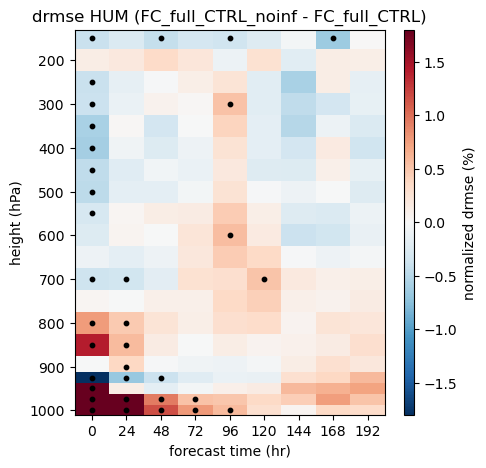

In [50]:
# Humidity (new; using precaluated global mean error)
# timeseries of dRMSE (exptest - expref)

save_fig = False

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/HUM/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

    
plt_region = 'global'

# turn the significant level into numpy matrix:
s95_mat = np.zeros((len(lev), len(fcsthrs)));
for t, hrs in enumerate(fcsthrs):
    s95_mat[:,t] = s95_q_region[exptest][hrs][plt_region]

# turn the significant level into numpy matrix:
plt_mat = np.zeros((len(lev), len(fcsthrs)));
for t, hrs in enumerate(fcsthrs):
    plt_mat[:,t] = dqg_norm[exptest][hrs][plt_region]*100
    
    
#x_axis = fcsthrs
x_axis = [int(x) for x in fcsthrs]
y_axis = lev

xx, yy = np.meshgrid(x_axis, y_axis)

fig, ax = plt.subplots(figsize=(5,5))
#plt_field = (q_rmse_timeseries[exptest] - q_rmse_timeseries[expref])/q_rmse_timeseries[expref]*100
contour = ax.pcolormesh(xx,yy,plt_mat, vmin=-1.8, vmax = 1.8, cmap='RdBu_r')
plt.scatter(np.ma.array(xx, mask=s95_mat), yy, s=10, color='black', marker='o')

#ax.set_xticks(fcsthrs)
ax.set_xticks(x_axis)

ax.invert_yaxis()

ax.set_xlabel('forecast time (hr)')
ax.set_ylabel('height (hPa)')
ax.set_title(f'drmse HUM ({exptest} - {expref})')
ax.set_ylim(1010,130)
# set colorbar
cbar = fig.colorbar(contour,location='right',aspect=40)
cbar.set_label('normalized drmse (%)')


if save_fig:
    plt.savefig(f"{fig_dir}/HUM_drmse_timeseries{region}_{exptest}_ref_{expref}.png")
plt.show()


In [ ]:
lev

In [ ]:
# Plot the dRMSE timeseries for humidity:

# Plot assigned levels:
plt_z = 500

for plt_region in ['NH', 'TR', 'SH']:
    # transform the d norm and ci_bar into numpy matrices:
    dnorm_mat = np.zeros((len(lev), len(fcsthrs)))
    cibar_mat = np.zeros((len(lev), len(fcsthrs)))

    for z,zz in enumerate(lev):    
        for t,tt in enumerate(fcsthrs):
            dnorm_mat[z,t] = dug_norm[exptest][tt][plt_region][z]*100
            cibar_mat[z,t] = d95_u_region[exptest][tt][plt_region][z]*100
            
    sel_z = np.where(lev == plt_z)[0][0]
    plt_var_name = rf'$\Delta$Q {plt_z} hPa'
    
    x_axis = [int(x) for x in fcsthrs]
    y_axis = dnorm_mat[sel_z, :]
    ci_bar = cibar_mat[sel_z, :]

    fig, ax = plt.subplots(figsize=(6,3))    
    ax.errorbar(x_axis, y_axis, color='black')
    ax.errorbar(x_axis, y_axis, yerr=ci_bar, fmt='s', color='black', ecolor='black', capsize=5, linestyle='None', markersize=4)
    ax.set_xticks(x_axis)
    ax.set_ylim(-2.5,2.5)
    ax.tick_params(axis='both', labelsize=12.5)
    ax.set_xlabel('Forecast Hours', fontsize=12.5)
    ax.set_ylabel(f'{plt_var_name} [%]', fontsize=12.5)
    ax.axhline(0, linestyle='--', color='black')
    ax.set_title(f'{plt_region}')
    plt.show()

In [ ]:
print(rf' $\Delta$ ')

In [ ]:
# Humidity (old, using the calculated a few blocks before)
# timeseries of dRMSE (exptest - expref)

save_fig = False

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/HUM/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

    
#x_axis = fcsthrs
x_axis = [int(x) for x in fcsthrs]
y_axis = lev

xx, yy = np.meshgrid(x_axis, y_axis)

fig, ax = plt.subplots(figsize=(5,5))
plt_field = (q_rmse_timeseries[exptest] - q_rmse_timeseries[expref])/q_rmse_timeseries[expref]*100
contour = ax.pcolormesh(xx,yy,plt_field, vmin=-1.8, vmax = 1.8, cmap='RdBu_r')
#plt.scatter(np.ma.array(xx, mask=s95_mat), yy, color='black', marker='+')

#ax.set_xticks(fcsthrs)
ax.set_xticks(x_axis)

ax.invert_yaxis()

ax.set_xlabel('forecast time (hr)')
ax.set_ylabel('height (hPa)')
ax.set_title(f'drmse HUM ({exptest} - {expref})')
ax.set_ylim(1000,100)
# set colorbar
cbar = fig.colorbar(contour,location='right',aspect=40)
cbar.set_label('normalized drmse (%)')


if save_fig:
    plt.savefig(f"{fig_dir}/HUM_drmse_timeseries{region}_{exptest}_ref_{expref}.png")
plt.show()

In [ ]:
# Temperature
# timeseries of dRMSE (exptest - expref)

save_fig = False

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/T/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

#x_axis = fcsthrs
x_axis = [int(x) for x in fcsthrs]
y_axis = lev

xx, yy = np.meshgrid(x_axis, y_axis)


fig, ax = plt.subplots(figsize=(5,5))
plt_field = (t_rmse_timeseries[exptest] - t_rmse_timeseries[expref])/t_rmse_timeseries[expref]*100
contour = ax.pcolormesh(xx,yy,plt_field, vmin=-1.8, vmax = 1.8, cmap='RdBu_r')
#ax.set_xticks(fcsthrs)
ax.set_xticks(x_axis)
ax.invert_yaxis()

ax.set_xlabel('forecast time (hr)')
ax.set_ylabel('height (hPa)')
ax.set_title(f'drmse T ({exptest} - {expref})')
#ax.set_ylim(1000,100)
# set colorbar
cbar = fig.colorbar(contour,location='right',aspect=40)
cbar.set_label('normalized drmse (%)')


if save_fig:
    plt.savefig(f"{fig_dir}/T_drmse_timeseries{region}_{exptest}_ref_{expref}.png")
plt.show()

In [ ]:
# U-wind
# timeseries of dRMSE (exptest - expref)

save_fig = False

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/U/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")


x_axis = fcsthrs
y_axis = lev

xx, yy = np.meshgrid(x_axis, y_axis)


fig, ax = plt.subplots(figsize=(5,5))
plt_field = (u_rmse_timeseries[exptest] - u_rmse_timeseries[expref])/u_rmse_timeseries[expref]*100
contour = ax.pcolormesh(xx,yy,plt_field, vmin=-1.8, vmax = 1.8, cmap='RdBu_r')
#ax.set_xticks(fcsthrs)
ax.set_xticks(x_axis)
ax.invert_yaxis()

ax.set_xlabel('forecast time (hr)')
ax.set_ylabel('height (hPa)')
ax.set_title(f'drmse U ({exptest} - {expref})')
ax.set_ylim(1000,100)
# set colorbar
cbar = fig.colorbar(contour,location='right',aspect=40)
cbar.set_label('normalized drmse (%)')


if save_fig:
    plt.savefig(f"{fig_dir}/U_drmse_timeseries{region}_{exptest}_ref_{expref}.png")
plt.show()

In [ ]:
# CLW
# timeseries of dRMSE (exptest - expref)

save_fig = False

fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/forecast_verification_ERA5/{exptest}_ref_{expref}/CLW/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")


#x_axis = fcsthrs
ax.set_xticks(x_axis)

y_axis = lev

xx, yy = np.meshgrid(x_axis, y_axis)


fig, ax = plt.subplots(figsize=(5,5))
plt_field = (clw_rmse_timeseries[exptest] - clw_rmse_timeseries[expref])/clw_rmse_timeseries[expref]*100
contour = ax.pcolormesh(xx,yy,plt_field, vmin=-1.8, vmax = 1.8, cmap='RdBu_r')
ax.set_xticks(fcsthrs)
ax.invert_yaxis()

ax.set_xlabel('forecast time (hr)')
ax.set_ylabel('height (hPa)')
ax.set_title(f'drmse CLW ({exptest} - {expref})')
ax.set_ylim(1000,100)
# set colorbar
cbar = fig.colorbar(contour,location='right',aspect=40)
cbar.set_label('normalized drmse (%)')


if save_fig:
    plt.savefig(f"{fig_dir}/CLW_drmse_timeseries{region}_{exptest}_ref_{expref}.png")
plt.show()

In [ ]:
lev

In [ ]:
plt.plot(dqg_norm['FC_full_clr_cld_low_sym_tri']['00'], lev)
plt.scatter(np.zeros(len(lev)), np.ma.array(lev, mask=s95_q_global['FC_full_clr_cld_low_sym_tri']['00']))
plt.ylim(1000,0)
plt.legend()

In [ ]:
import matplotlib.colors as mcolors

# Create a custom colormap
cmap = plt.get_cmap('RdBu_r')  # Use reversed RdBu for blue-red transition

# Modify the center to have a larger white region
colors = cmap(np.linspace(0, 1, 100))
#colors[45:55] = [1, 1, 1, 1]  # Force more values to be pure white (40%-60% range)

# Create a new colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_RdBu', colors)